### Импорт зависимостей

In [2]:
import typing

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from PIL import Image
from transformers import pipeline
from torchvision.datasets import CocoDetection

### Создание словаря

In [3]:
class TTranslator:
    CLASSES: typing.Final[list[str]] = [
        "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
        "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
        "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
        "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
        "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
        "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
        "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop",
        "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
        "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]
    RUSSIAN_CLASSES: typing.Final[list[str]] = [
        "человек", "велосипед", "автомобиль", "мотоцикл", "самолёт", "автобус", "поезд", "грузовик", "лодка",
        "светофор", "пожарный гидрант", "знак стоп", "парковочный счётчик", "скамейка", "птица", "кошка",
        "собака", "лошадь", "овца", "корова", "слон", "медведь", "зебра", "жираф", "рюкзак",
        "зонт", "дамская сумка", "галстук", "чемодан", "фрисби", "лыжи", "сноуборд", "спортивный мяч",
        "воздушный змей", "бейсбольная бита", "бейсбольная перчатка", "скейтборд", "доска для сёрфинга", "теннисная ракетка",
        "бутылка", "бокал", "чашка", "вилка", "нож", "ложка", "миска", "банан", "яблоко",
        "бутерброд", "апельсин", "брокколи", "морковь", "хот-дог", "пицца", "пончик", "торт",
        "стул", "диван", "комнатное растение", "кровать", "обеденный стол", "унитаз", "телевизор", "ноутбук",
        "компьютерная мышь", "пульт", "клавиатура", "смартфон", "микроволновка", "духовка", "тостер", "раковина",
        "холодильник", "книга", "часы", "ваза", "ножницы", "плюшевый мишка", "фен", "зубная щётка"
    ]

    def __init__(self):
        self.russian: typing.Final[dict[str, str]] = dict(zip(self.CLASSES, self.RUSSIAN_CLASSES))

    def to_russian(self, word: str) -> str | None:
        return self.russian.get(word)


translator = TTranslator()

### Создание классификатора

In [4]:
class TCocoClassifier:
    CATEGORIES: typing.Final[dict[str, set[str]]] = {
        "люди": {"человек"},
        "транспорт": {
            "велосипед", "автомобиль", "мотоцикл", "самолёт",
            "автобус", "поезд", "грузовик", "лодка"
        },
        "животные": {
            "птица", "кошка", "собака", "лошадь", "овца",
            "корова", "слон", "медведь", "зебра", "жираф"
        },
        "еда": {
            "банан", "яблоко", "бутерброд", "апельсин", "брокколи",
            "морковь", "хот-дог", "пицца", "пончик", "торт"
        },
        "мебель": {
            "стул", "диван", "кровать", "обеденный стол"
        },
        "техника": {
            "телевизор", "ноутбук", "компьютерная мышь", "пульт",
            "клавиатура", "смартфон", "микроволновка", "духовка",
            "тостер", "холодильник"
        },
        "одежда": {
            "часы", "дамская сумка", "рюкзак"
        }
    }

    def classify(self, word: str) -> str:
        for cat, values in self.CATEGORIES.items():
            if word in values:
                return cat

        return "прочее"


classifier = TCocoClassifier()

### Класс-помощник для получения цвета из категории

In [5]:
class TColorGetter:
    CATEGORY_TO_COLOR: typing.Final[dict[str, str]] = {
        "люди": "coral",
        "транспорт": "steelblue",
        "животные": "sandybrown",
        "еда": "tomato",
        "мебель": "sienna",
        "техника": "slategray",
        "одежда": "green",
        "прочее": "silver"
    }

    def get(self, category: str) -> str:
        return self.CATEGORY_TO_COLOR[category]


color_getter = TColorGetter()

### Создание класса, описывающего изображение

In [ ]:
class TImagePlotter:
    def __init__(self, translator: TTranslator, classifier: TCocoClassifier, color_getter: TColorGetter):
        self.translator = translator
        self.classifier = classifier
        self.color_getter = color_getter

    def plot(self, image, image_infos):
        plt.figure(figsize=(image.width / 100, image.height / 100))
        plt.imshow(image)
        ax = plt.gca()
        legend_elements = [
            patches.Patch(facecolor=color, edgecolor=color, label=label)
            for label, color in self.color_getter.CATEGORY_TO_COLOR.items()
        ]
        ax.legend(handles=legend_elements, loc="upper right")

        for info in image_infos:
            xmin, ymin, xmax, ymax = info["box"].values()
            width, height = xmax - xmin, ymax - ymin

            label_en = info["label"]
            label_ru = self.translator.to_russian(label_en)

            category = self.classifier.classify(label_ru)
            color = self.color_getter.get(category)

            rect = patches.Rectangle(
                (xmin, ymin), width, height, linewidth=2, edgecolor=color, facecolor="none", alpha=0.8
            )
            ax.add_patch(rect)

            ax.text(
                xmin,
                ymin - 5 if ymin > 20 else ymin + height + 5,
                label_ru,
                color="black",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
            )

        plt.axis("off")
        plt.tight_layout()
        plt.show()


plotter = TImagePlotter(translator, classifier, color_getter)

### Создание модели

In [ ]:
model_name = "facebook/detr-resnet-50"
detector = pipeline("object-detection", model=model_name)

### Получение данных и отрисовка

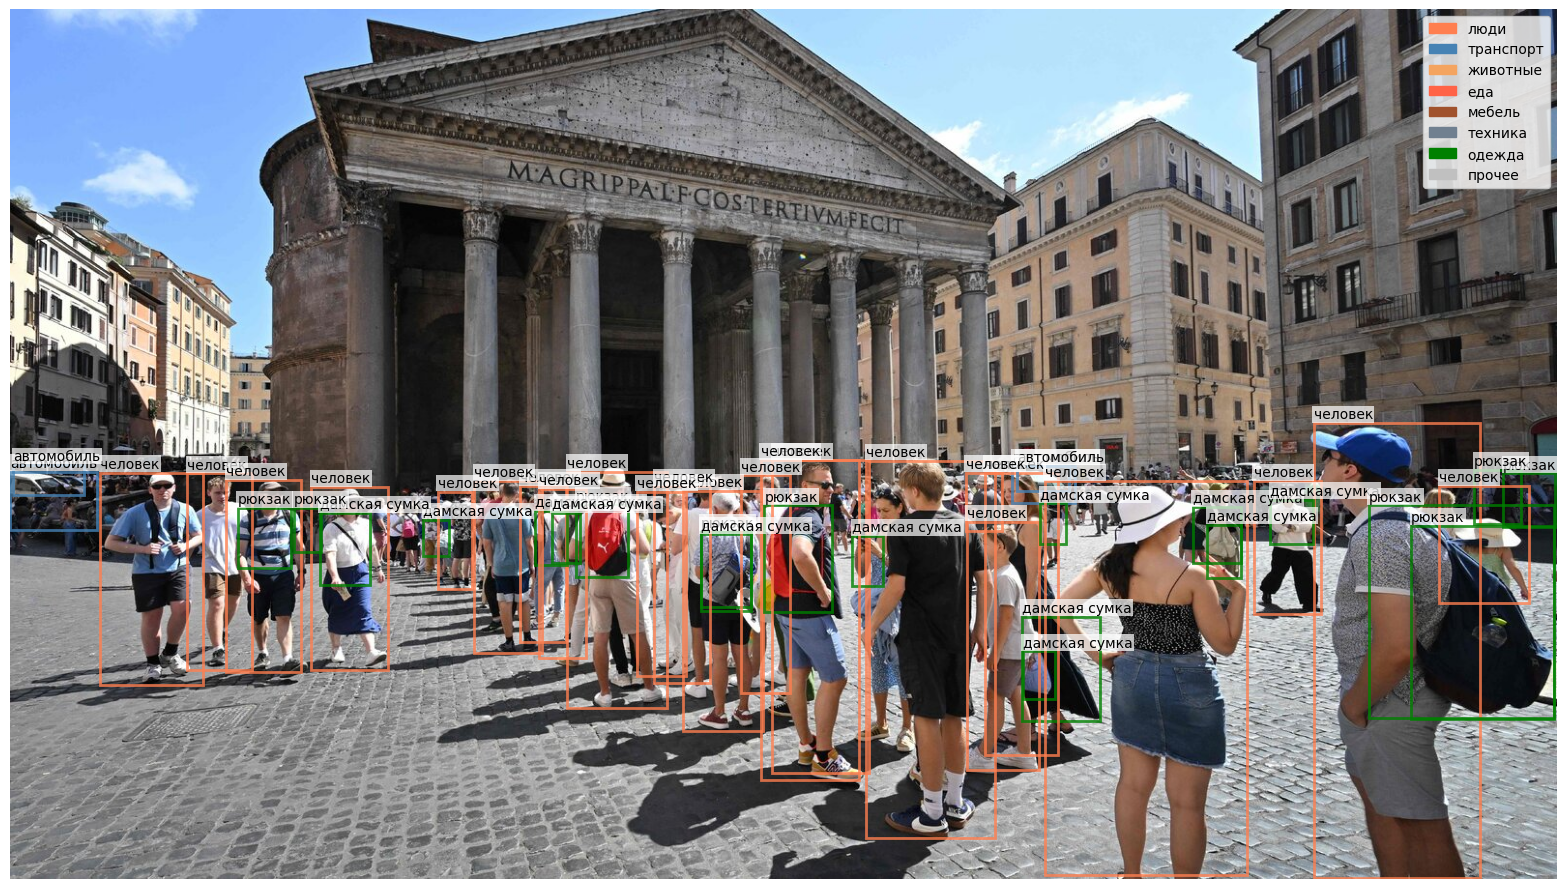

In [11]:
image_path = "data/italy.jpg"
image = Image.open(image_path)
image_infos = detector(image)
plotter.plot(image, image_infos)

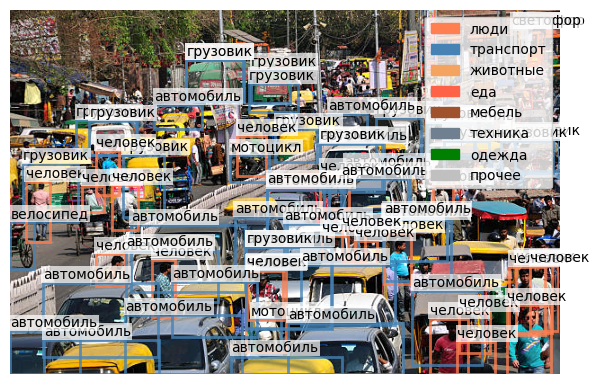

In [12]:
image_path = "data/jam.jpg"
image = Image.open(image_path)
image_infos = detector(image)
plotter.plot(image, image_infos)